In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *

# Recall and hamming error rate

In [2]:
ncells = [50, 75, 100, 125, 150, 175, 200]
chroms = ["chr%s" % c for c in range(1, 23)] + ["chrX"]

In [3]:
rows = []
for ncell in ncells:
    path = "../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_%d/round2/snvs_benchmark.json" % ncell
    d = json.load(open(path))    
    recall1 = d["Het_SNP_Recall"]
    precision1 = d["Phasing_Precision"]
    path = "../../4_NanoStrandSeq_Phasing/results/Mouse_Cell_%d/whatshap/phased_nss.benchmark_phasing.json" % ncell
    d = json.load(open(path))
    recall2 = d["Phasing_Recall"]
    precision2 = d["Phasing_Precision"]
    rows.append([ncell, recall1, precision1, recall2, precision2])
df = pd.DataFrame(rows, columns=["Cells", "Recall1", "Precision1", "Recall2", "Precision2"])
df["ErrorRate1"] = 1 - df["Precision1"]
df["ErrorRate2"] = 1 - df["Precision2"]
df.to_csv("results/benchmark_of_hetsnp.round2_vs_knownsnps.Mouse.tsv", sep="\t", index=False)
df

,Cells,Recall1,Precision1,Recall2,Precision2,ErrorRate1,ErrorRate2
0,50,0.052056,0.993041,0.676359,0.968321,0.006959,0.031679
1,75,0.163659,0.997698,0.907023,0.978332,0.002302,0.021668
2,100,0.300920,0.998897,0.964765,0.996605,0.001103,0.003395
3,125,0.432245,0.999508,0.977527,0.997377,0.000492,0.002623
4,150,0.535277,0.999653,0.982355,0.996999,0.000347,0.003001
5,175,0.601194,0.999848,0.984681,0.997897,0.000152,0.002103
6,200,0.656248,0.999926,0.986218,0.997299,0.000074,0.002701


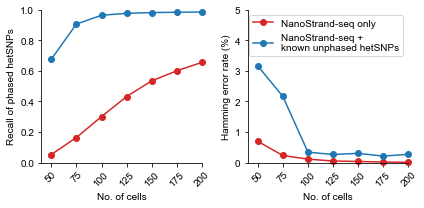

In [5]:
xs = df["Cells"]

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True)

plt.sca(axs[0])
ys1 = df["Recall1"]
ys2 = df["Recall2"]
plt.plot(xs, ys1, marker="o", color="C3", clip_on=False, label="NanoStrand-seq only")
plt.plot(xs, ys2, marker="o", color="C0", clip_on=False, label="NanoStrand-seq +\nknown unphased hetSNPs")
plt.xlabel("No. of cells")
plt.ylabel("Recall of phased hetSNPs")
plt.xlim(min(xs) - 10, max(xs))
plt.ylim(0, 1)
plt.xticks(xs, rotation=45)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
# plt.legend()

plt.sca(axs[1])
ys1 = (1 - df["Precision1"]) * 100
ys2 = (1 - df["Precision2"]) * 100
plt.plot(xs, ys1, marker="o", color="C3", clip_on=False, label="NanoStrand-seq only")
plt.plot(xs, ys2, marker="o", color="C0", clip_on=False, label="NanoStrand-seq +\nknown unphased hetSNPs")
plt.xlabel("No. of cells")
plt.ylabel("Hamming error rate (%)")
plt.xlim(min(xs) - 10, max(xs))
plt.ylim(0, 5)
plt.yticks([0, 1, 2, 3, 4, 5])
plt.xticks(xs, rotation=45)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()

plt.tight_layout()
plt.savefig("figures/benchmark_het_snps.comb.mouse.pdf", dpi=300)

# Added GT tag for SVs

In [37]:
ncells = [50, 100, 150, 200]

for ncell in ncells:
    path1 = "../../A1_NanoStrandseqAssembly/results/Mouse_Cell_%d/sv/quantify_lite.tsv" % ncell
    path2 = "data/quant_phased_svs.Mouse_Cell_%d.tsv" % ncell
    
    dat = pd.read_csv(path1, sep="\t")
    
    if False: # loose
        min_cell = 1
        min_read = 2
        foldchange = 2
    else: # stringent
        min_cell = 2
        min_read = 4
        foldchange = 3

    for hp in ["HP1", "HP2"]:
        values = dat[["AgreeRead_%s" % hp, "AgreeCell_%s" % hp, "DisagreeRead_%s" % hp, "DisagreeCell_%s" % hp]].values
        ts = []
        for agree_read, agree_cell, disagree_read, disagree_cell in values:
            t = "Uncertain" # Exist, NotExist
            if agree_cell >= min_cell and agree_cell >= disagree_cell * foldchange \
                and agree_read >= min_read and agree_read >= disagree_read * foldchange:
                t = "Exist"
            if disagree_cell >= min_cell and disagree_cell >= agree_cell * foldchange \
                and disagree_read >= min_read and disagree_read >= agree_read * foldchange:
                assert t != "Exist"
                t = "NotExist"
            ts.append(t)
        dat["Existence_%s" % hp] = ts
        
    gts = []
    for v1, v2 in dat[["Existence_HP1", "Existence_HP2"]].values:
        gt = "."
        if v1 == "Exist":
            if v2 == "Exist":
                gt = "1|1"
            elif v2 == "NotExist":
                gt = "1|0"
        elif v1 == "NotExist":
            if v2 == "Exist":
                gt = "0|1"
        gts.append(gt)
    dat["GenoType"] = gts
    
    dat.to_csv(path2, sep="\t", index=False)